In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [42]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
# Statt MNIST laden wir nun den FashionMNIST Datensatz
train_data = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)


0


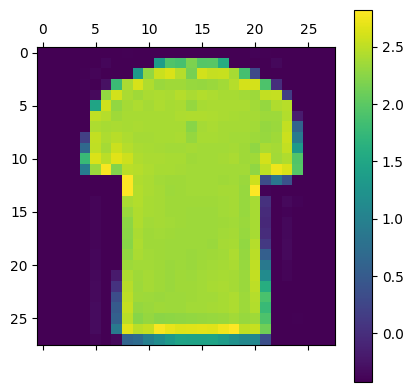

In [310]:
img, label = train_data[4691]

plt.matshow(img[0])
plt.colorbar()
print(label)

In [312]:
from norse.torch import ConstantCurrentLIFEncoder

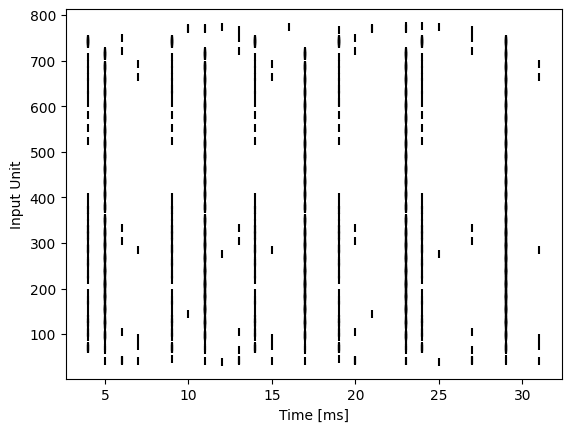

In [314]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [302]:
from norse.torch import PoissonEncoder

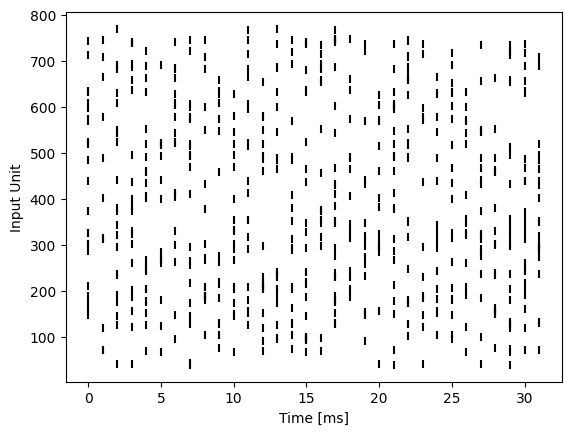

In [304]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [306]:
from norse.torch import SpikeLatencyLIFEncoder

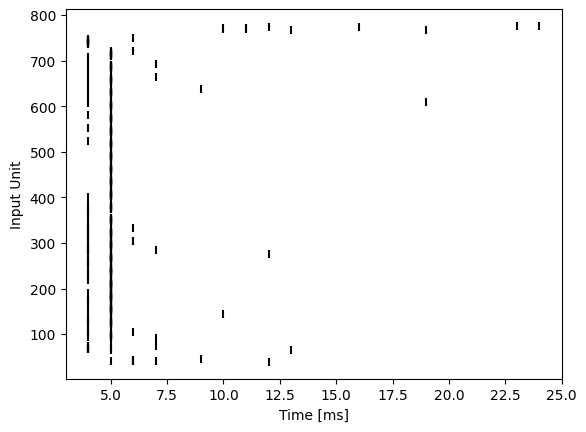

In [308]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [316]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

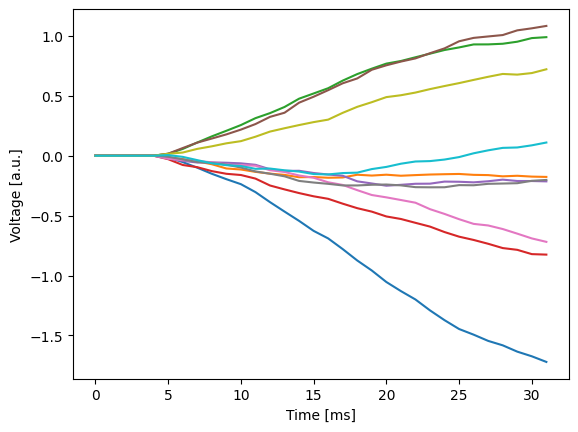

In [318]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

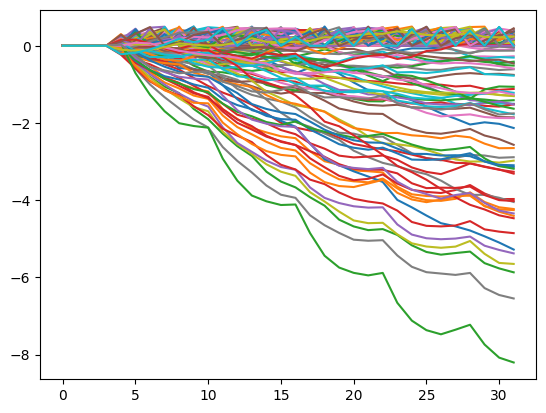

In [320]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

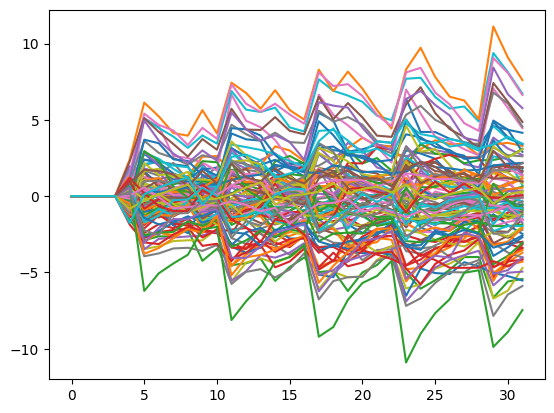

In [322]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [324]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [326]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [328]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [330]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode_last,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [332]:
from tqdm.notebook import tqdm, trange

EPOCHS = 60


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [334]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [336]:
from torch.utils.data import random_split

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_data))  # 20% für Validierung
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# DataLoader für den Validierungsdatensatz
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [338]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100.0 * correct / len(val_loader.dataset)

    return val_loss, accuracy


In [340]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.7576, Test Loss: 0.6005, Validation Loss: 0.5693, Accuracy: 78.57%, Validation Accuracy: 79.67%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.5506, Test Loss: 0.5653, Validation Loss: 0.5210, Accuracy: 79.82%, Validation Accuracy: 81.41%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.5097, Test Loss: 0.5491, Validation Loss: 0.4965, Accuracy: 79.71%, Validation Accuracy: 81.72%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.4835, Test Loss: 0.5328, Validation Loss: 0.4753, Accuracy: 80.89%, Validation Accuracy: 82.76%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.4657, Test Loss: 0.5243, Validation Loss: 0.4602, Accuracy: 80.82%, Validation Accuracy: 83.04%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.4500, Test Loss: 0.5091, Validation Loss: 0.4295, Accuracy: 82.15%, Validation Accuracy: 84.47%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.4355, Test Loss: 0.5310, Validation Loss: 0.4507, Accuracy: 80.59%, Validation Accuracy: 83.33%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.4211, Test Loss: 0.5065, Validation Loss: 0.4151, Accuracy: 82.20%, Validation Accuracy: 85.05%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.4103, Test Loss: 0.4942, Validation Loss: 0.4070, Accuracy: 82.35%, Validation Accuracy: 85.04%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.3993, Test Loss: 0.5179, Validation Loss: 0.4207, Accuracy: 81.58%, Validation Accuracy: 84.66%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.3979, Test Loss: 0.4918, Validation Loss: 0.3949, Accuracy: 82.48%, Validation Accuracy: 85.45%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.3842, Test Loss: 0.4788, Validation Loss: 0.3763, Accuracy: 82.98%, Validation Accuracy: 86.35%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.3811, Test Loss: 0.4828, Validation Loss: 0.3745, Accuracy: 83.44%, Validation Accuracy: 86.46%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.3766, Test Loss: 0.4766, Validation Loss: 0.3581, Accuracy: 82.99%, Validation Accuracy: 86.87%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.3688, Test Loss: 0.4950, Validation Loss: 0.3776, Accuracy: 82.41%, Validation Accuracy: 86.10%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.3641, Test Loss: 0.4854, Validation Loss: 0.3659, Accuracy: 82.66%, Validation Accuracy: 86.69%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.3597, Test Loss: 0.4809, Validation Loss: 0.3510, Accuracy: 83.38%, Validation Accuracy: 87.28%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.3564, Test Loss: 0.4850, Validation Loss: 0.3516, Accuracy: 83.15%, Validation Accuracy: 87.00%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.3504, Test Loss: 0.4603, Validation Loss: 0.3296, Accuracy: 84.17%, Validation Accuracy: 88.18%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.3442, Test Loss: 0.4815, Validation Loss: 0.3615, Accuracy: 83.07%, Validation Accuracy: 86.84%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.3436, Test Loss: 0.4764, Validation Loss: 0.3326, Accuracy: 83.51%, Validation Accuracy: 88.02%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.3384, Test Loss: 0.4766, Validation Loss: 0.3254, Accuracy: 83.54%, Validation Accuracy: 88.11%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.3322, Test Loss: 0.4885, Validation Loss: 0.3448, Accuracy: 82.82%, Validation Accuracy: 87.29%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.3309, Test Loss: 0.4699, Validation Loss: 0.3149, Accuracy: 84.13%, Validation Accuracy: 88.62%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.3309, Test Loss: 0.4616, Validation Loss: 0.3082, Accuracy: 83.98%, Validation Accuracy: 88.81%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.3214, Test Loss: 0.4684, Validation Loss: 0.3127, Accuracy: 83.72%, Validation Accuracy: 88.74%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.3158, Test Loss: 0.4736, Validation Loss: 0.3113, Accuracy: 83.44%, Validation Accuracy: 88.30%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.3127, Test Loss: 0.4701, Validation Loss: 0.3067, Accuracy: 84.03%, Validation Accuracy: 88.73%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.3115, Test Loss: 0.4829, Validation Loss: 0.3221, Accuracy: 83.80%, Validation Accuracy: 88.09%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.3058, Test Loss: 0.4775, Validation Loss: 0.2969, Accuracy: 83.68%, Validation Accuracy: 88.94%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.3040, Test Loss: 0.4867, Validation Loss: 0.2923, Accuracy: 83.79%, Validation Accuracy: 89.46%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.3046, Test Loss: 0.4883, Validation Loss: 0.2947, Accuracy: 83.67%, Validation Accuracy: 89.33%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.2998, Test Loss: 0.5071, Validation Loss: 0.3111, Accuracy: 83.16%, Validation Accuracy: 88.45%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.2932, Test Loss: 0.4943, Validation Loss: 0.3015, Accuracy: 83.68%, Validation Accuracy: 88.92%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.2917, Test Loss: 0.4740, Validation Loss: 0.2769, Accuracy: 84.06%, Validation Accuracy: 89.84%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.2894, Test Loss: 0.4739, Validation Loss: 0.2727, Accuracy: 83.89%, Validation Accuracy: 90.01%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.2842, Test Loss: 0.5077, Validation Loss: 0.3066, Accuracy: 83.07%, Validation Accuracy: 88.62%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.2857, Test Loss: 0.4746, Validation Loss: 0.2783, Accuracy: 84.11%, Validation Accuracy: 89.88%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.2809, Test Loss: 0.4907, Validation Loss: 0.2720, Accuracy: 83.98%, Validation Accuracy: 90.37%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.2743, Test Loss: 0.4950, Validation Loss: 0.2756, Accuracy: 84.04%, Validation Accuracy: 90.13%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.2653, Test Loss: 0.4796, Validation Loss: 0.2511, Accuracy: 84.40%, Validation Accuracy: 90.85%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.2746, Test Loss: 0.4973, Validation Loss: 0.2516, Accuracy: 84.00%, Validation Accuracy: 90.66%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.2639, Test Loss: 0.4719, Validation Loss: 0.2400, Accuracy: 84.63%, Validation Accuracy: 91.03%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.2588, Test Loss: 0.4929, Validation Loss: 0.2531, Accuracy: 84.49%, Validation Accuracy: 90.74%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.2564, Test Loss: 0.4952, Validation Loss: 0.2480, Accuracy: 83.98%, Validation Accuracy: 90.98%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.2542, Test Loss: 0.4803, Validation Loss: 0.2470, Accuracy: 84.56%, Validation Accuracy: 90.98%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.2565, Test Loss: 0.4885, Validation Loss: 0.2440, Accuracy: 84.36%, Validation Accuracy: 90.85%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.2552, Test Loss: 0.5187, Validation Loss: 0.2584, Accuracy: 83.89%, Validation Accuracy: 90.32%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.2547, Test Loss: 0.5111, Validation Loss: 0.2348, Accuracy: 84.11%, Validation Accuracy: 91.35%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.2495, Test Loss: 0.5108, Validation Loss: 0.2394, Accuracy: 84.12%, Validation Accuracy: 91.47%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.2506, Test Loss: 0.5054, Validation Loss: 0.2334, Accuracy: 83.87%, Validation Accuracy: 91.46%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.2384, Test Loss: 0.5052, Validation Loss: 0.2307, Accuracy: 84.37%, Validation Accuracy: 91.53%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.2442, Test Loss: 0.5081, Validation Loss: 0.2404, Accuracy: 84.00%, Validation Accuracy: 91.42%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.2446, Test Loss: 0.5040, Validation Loss: 0.2279, Accuracy: 84.67%, Validation Accuracy: 91.59%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.2417, Test Loss: 0.5183, Validation Loss: 0.2416, Accuracy: 84.14%, Validation Accuracy: 91.03%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.2355, Test Loss: 0.5150, Validation Loss: 0.2143, Accuracy: 84.21%, Validation Accuracy: 92.12%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.2305, Test Loss: 0.5182, Validation Loss: 0.2187, Accuracy: 83.83%, Validation Accuracy: 91.91%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.2349, Test Loss: 0.5152, Validation Loss: 0.2348, Accuracy: 83.93%, Validation Accuracy: 91.11%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.2308, Test Loss: 0.5144, Validation Loss: 0.2146, Accuracy: 84.43%, Validation Accuracy: 92.08%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.2220, Test Loss: 0.5214, Validation Loss: 0.2155, Accuracy: 84.10%, Validation Accuracy: 92.12%
Final Test Accuracy: 84.10%
Final Validation Accuracy: 92.12%


torch.Size([32, 1, 10])


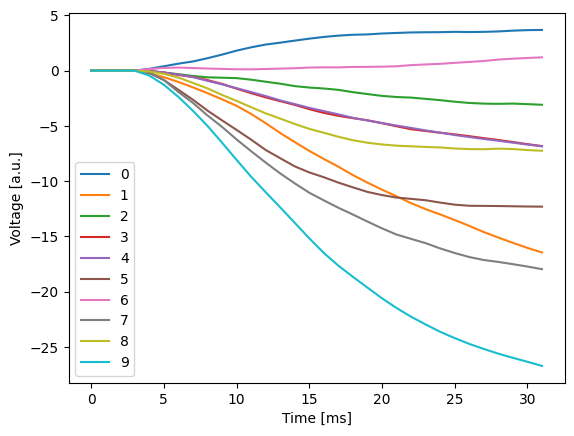

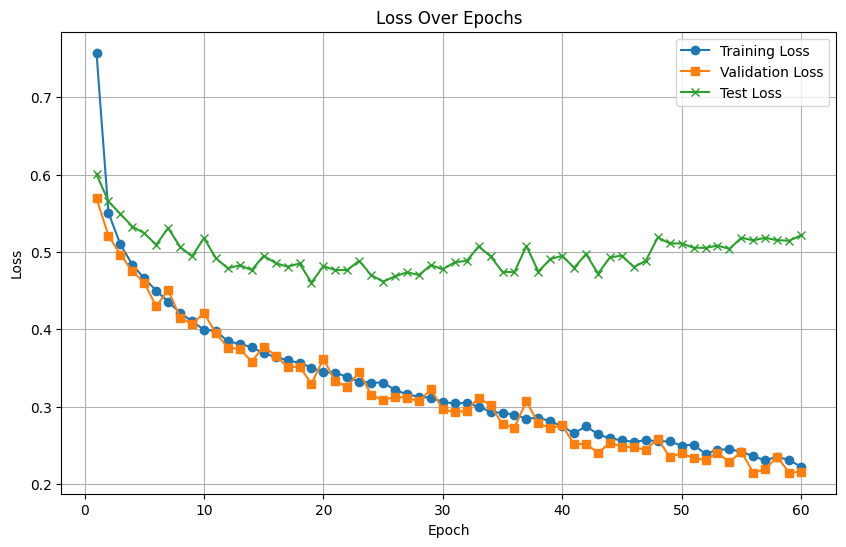

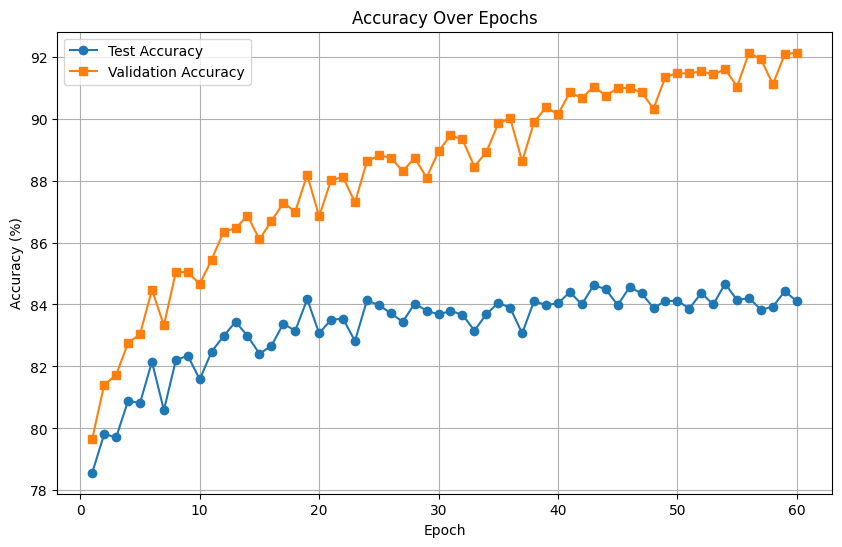

In [342]:
trained_snn = model.snn.cpu()

# Beginn 11:38 60 Epochen Ende 11:54


trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()


# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker="x")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Test Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


5 Epochen
final accuracy: 81.37 mit decode

15 Epochs final accuracy: 83.66 mit decode

5 Epochs final accuracy: 81.78 mit decode_last

15 Epochs final accuracy: 83.72 mit decode_last

## Modifying --> SpikeLatencyLIFEncoder

In [60]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

In [62]:
# from norse.torch.module import encode

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.SpikeLatencyLIFEncoder(T),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [66]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.2491, Test Loss: 0.5155, Validation Loss: 0.2452, Accuracy: 84.00%, Validation Accuracy: 90.74%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.2449, Test Loss: 0.4997, Validation Loss: 0.2391, Accuracy: 84.12%, Validation Accuracy: 91.30%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.2443, Test Loss: 0.5020, Validation Loss: 0.2283, Accuracy: 84.10%, Validation Accuracy: 91.53%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.2394, Test Loss: 0.4989, Validation Loss: 0.2319, Accuracy: 84.29%, Validation Accuracy: 91.37%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.2392, Test Loss: 0.4914, Validation Loss: 0.2277, Accuracy: 84.51%, Validation Accuracy: 91.55%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.2417, Test Loss: 0.5033, Validation Loss: 0.2375, Accuracy: 84.01%, Validation Accuracy: 91.00%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.2371, Test Loss: 0.5007, Validation Loss: 0.2273, Accuracy: 84.50%, Validation Accuracy: 91.46%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.2395, Test Loss: 0.5127, Validation Loss: 0.2421, Accuracy: 83.80%, Validation Accuracy: 91.28%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.2434, Test Loss: 0.5290, Validation Loss: 0.2495, Accuracy: 83.36%, Validation Accuracy: 90.47%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.2381, Test Loss: 0.5496, Validation Loss: 0.2621, Accuracy: 82.99%, Validation Accuracy: 89.97%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.2371, Test Loss: 0.5171, Validation Loss: 0.2357, Accuracy: 83.78%, Validation Accuracy: 91.05%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.2304, Test Loss: 0.5192, Validation Loss: 0.2295, Accuracy: 83.48%, Validation Accuracy: 91.50%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.2299, Test Loss: 0.5281, Validation Loss: 0.2195, Accuracy: 84.08%, Validation Accuracy: 91.83%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.2268, Test Loss: 0.5264, Validation Loss: 0.2239, Accuracy: 83.99%, Validation Accuracy: 91.56%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.2273, Test Loss: 0.5250, Validation Loss: 0.2114, Accuracy: 83.81%, Validation Accuracy: 92.26%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.2231, Test Loss: 0.5544, Validation Loss: 0.2240, Accuracy: 83.71%, Validation Accuracy: 91.28%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.2275, Test Loss: 0.5355, Validation Loss: 0.2214, Accuracy: 83.63%, Validation Accuracy: 91.76%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.2268, Test Loss: 0.5164, Validation Loss: 0.2091, Accuracy: 84.28%, Validation Accuracy: 92.04%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.2174, Test Loss: 0.5348, Validation Loss: 0.2084, Accuracy: 83.50%, Validation Accuracy: 92.39%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.2149, Test Loss: 0.5369, Validation Loss: 0.2077, Accuracy: 83.74%, Validation Accuracy: 92.40%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.2176, Test Loss: 0.5341, Validation Loss: 0.2060, Accuracy: 84.08%, Validation Accuracy: 92.41%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.2115, Test Loss: 0.5601, Validation Loss: 0.2125, Accuracy: 83.58%, Validation Accuracy: 92.02%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.2144, Test Loss: 0.5368, Validation Loss: 0.1945, Accuracy: 84.18%, Validation Accuracy: 92.80%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.2133, Test Loss: 0.5425, Validation Loss: 0.1933, Accuracy: 84.16%, Validation Accuracy: 92.59%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.2119, Test Loss: 0.5443, Validation Loss: 0.2044, Accuracy: 83.92%, Validation Accuracy: 92.21%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.2102, Test Loss: 0.5351, Validation Loss: 0.1979, Accuracy: 83.95%, Validation Accuracy: 92.78%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.2054, Test Loss: 0.5547, Validation Loss: 0.1881, Accuracy: 84.28%, Validation Accuracy: 93.08%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.2051, Test Loss: 0.5379, Validation Loss: 0.1852, Accuracy: 84.27%, Validation Accuracy: 93.33%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.2033, Test Loss: 0.5425, Validation Loss: 0.1918, Accuracy: 84.04%, Validation Accuracy: 93.03%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.2065, Test Loss: 0.5440, Validation Loss: 0.1995, Accuracy: 84.31%, Validation Accuracy: 92.51%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.2069, Test Loss: 0.5330, Validation Loss: 0.2039, Accuracy: 83.97%, Validation Accuracy: 92.45%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.2035, Test Loss: 0.5388, Validation Loss: 0.1889, Accuracy: 83.58%, Validation Accuracy: 93.09%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.2035, Test Loss: 0.5405, Validation Loss: 0.1991, Accuracy: 84.35%, Validation Accuracy: 92.72%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.2020, Test Loss: 0.5493, Validation Loss: 0.1848, Accuracy: 83.52%, Validation Accuracy: 93.29%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.1971, Test Loss: 0.5605, Validation Loss: 0.1884, Accuracy: 83.84%, Validation Accuracy: 93.02%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.1977, Test Loss: 0.5541, Validation Loss: 0.1866, Accuracy: 83.91%, Validation Accuracy: 93.25%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.1929, Test Loss: 0.5749, Validation Loss: 0.2058, Accuracy: 83.86%, Validation Accuracy: 92.17%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.1937, Test Loss: 0.5608, Validation Loss: 0.1793, Accuracy: 84.22%, Validation Accuracy: 93.29%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.1884, Test Loss: 0.5640, Validation Loss: 0.1841, Accuracy: 84.24%, Validation Accuracy: 93.14%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.1913, Test Loss: 0.5717, Validation Loss: 0.1845, Accuracy: 84.01%, Validation Accuracy: 93.09%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.1921, Test Loss: 0.5804, Validation Loss: 0.1921, Accuracy: 83.62%, Validation Accuracy: 92.84%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.1928, Test Loss: 0.5767, Validation Loss: 0.1710, Accuracy: 83.88%, Validation Accuracy: 93.63%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.1829, Test Loss: 0.5850, Validation Loss: 0.1745, Accuracy: 84.07%, Validation Accuracy: 93.65%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.1908, Test Loss: 0.6075, Validation Loss: 0.1927, Accuracy: 83.61%, Validation Accuracy: 92.61%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.1867, Test Loss: 0.5859, Validation Loss: 0.1745, Accuracy: 83.87%, Validation Accuracy: 93.54%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.1864, Test Loss: 0.5739, Validation Loss: 0.1828, Accuracy: 83.62%, Validation Accuracy: 93.22%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.1848, Test Loss: 0.5879, Validation Loss: 0.1760, Accuracy: 83.88%, Validation Accuracy: 93.30%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.1834, Test Loss: 0.5865, Validation Loss: 0.1753, Accuracy: 83.59%, Validation Accuracy: 93.56%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.1848, Test Loss: 0.5927, Validation Loss: 0.1736, Accuracy: 84.17%, Validation Accuracy: 93.58%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.1820, Test Loss: 0.5663, Validation Loss: 0.1707, Accuracy: 84.17%, Validation Accuracy: 93.83%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.1741, Test Loss: 0.6070, Validation Loss: 0.1654, Accuracy: 84.18%, Validation Accuracy: 93.88%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.1779, Test Loss: 0.5950, Validation Loss: 0.1610, Accuracy: 84.13%, Validation Accuracy: 93.92%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.1799, Test Loss: 0.5793, Validation Loss: 0.1702, Accuracy: 83.85%, Validation Accuracy: 93.90%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.1725, Test Loss: 0.5926, Validation Loss: 0.1604, Accuracy: 84.02%, Validation Accuracy: 93.99%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.1777, Test Loss: 0.6124, Validation Loss: 0.1888, Accuracy: 83.59%, Validation Accuracy: 93.12%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.1730, Test Loss: 0.5994, Validation Loss: 0.1741, Accuracy: 83.69%, Validation Accuracy: 93.34%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.1739, Test Loss: 0.5919, Validation Loss: 0.1587, Accuracy: 83.95%, Validation Accuracy: 94.18%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.1768, Test Loss: 0.5868, Validation Loss: 0.1539, Accuracy: 83.92%, Validation Accuracy: 94.17%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.1703, Test Loss: 0.6198, Validation Loss: 0.1796, Accuracy: 83.36%, Validation Accuracy: 93.37%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.1666, Test Loss: 0.6139, Validation Loss: 0.1687, Accuracy: 83.90%, Validation Accuracy: 93.55%
Final Test Accuracy: 83.90%
Final Validation Accuracy: 93.55%


15 Epochs final accuracy: 82.73 mit decode

torch.Size([32, 1, 10])


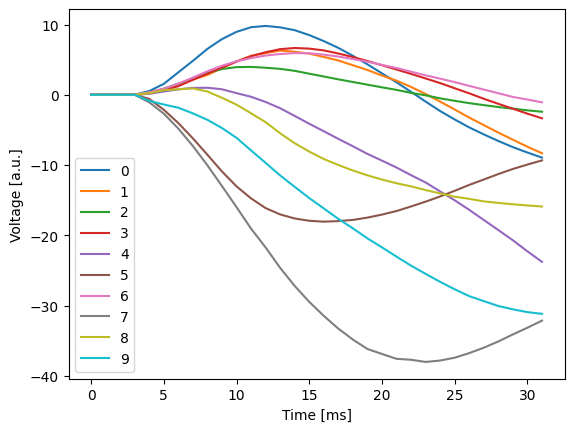

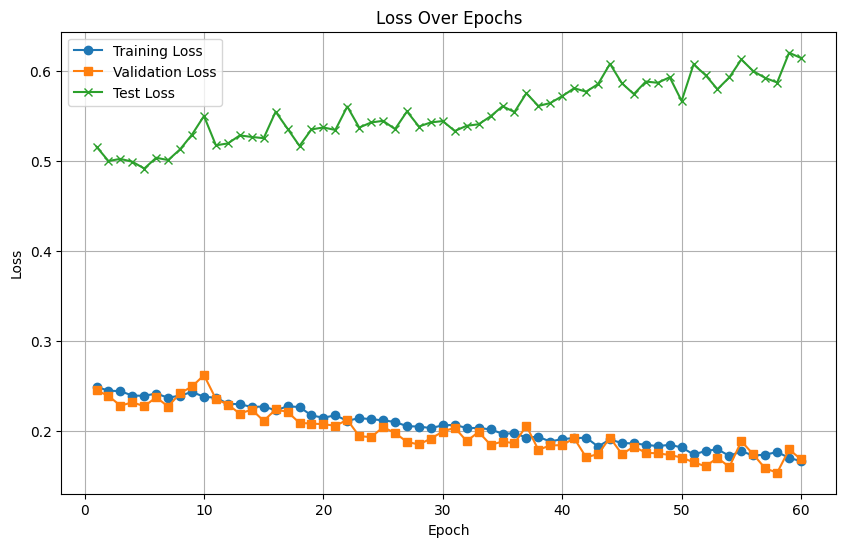

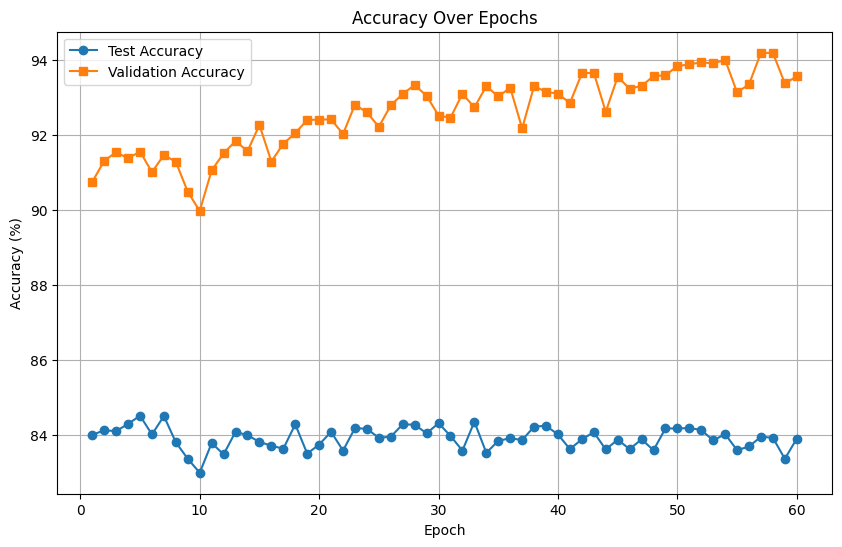

In [68]:
trained_snn = model.snn.cpu()

# Beginn 12:12 60 Epochen Ende 12:32


trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()


# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker="x")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Test Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Poison input

In [70]:
T = 32
LR = 0.005
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 200
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.PoissonEncoder(T, f_max=20),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=200, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=200, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [72]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.7901, Test Loss: 0.6646, Validation Loss: 0.6207, Accuracy: 75.78%, Validation Accuracy: 76.92%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.6394, Test Loss: 0.6455, Validation Loss: 0.6121, Accuracy: 76.18%, Validation Accuracy: 77.19%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.6178, Test Loss: 0.6603, Validation Loss: 0.6215, Accuracy: 76.29%, Validation Accuracy: 77.54%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.6096, Test Loss: 0.6159, Validation Loss: 0.5845, Accuracy: 77.36%, Validation Accuracy: 78.62%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.5985, Test Loss: 0.6263, Validation Loss: 0.5986, Accuracy: 77.64%, Validation Accuracy: 78.20%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.5876, Test Loss: 0.6247, Validation Loss: 0.5817, Accuracy: 76.87%, Validation Accuracy: 78.42%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.5827, Test Loss: 0.5780, Validation Loss: 0.5483, Accuracy: 78.65%, Validation Accuracy: 79.80%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.5877, Test Loss: 0.5841, Validation Loss: 0.5598, Accuracy: 78.93%, Validation Accuracy: 80.01%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.5762, Test Loss: 0.5927, Validation Loss: 0.5633, Accuracy: 77.82%, Validation Accuracy: 79.51%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.5754, Test Loss: 0.5904, Validation Loss: 0.5636, Accuracy: 77.83%, Validation Accuracy: 79.37%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.5502, Test Loss: 0.6252, Validation Loss: 0.5994, Accuracy: 75.73%, Validation Accuracy: 76.75%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.5497, Test Loss: 0.6156, Validation Loss: 0.5765, Accuracy: 76.73%, Validation Accuracy: 78.37%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.5483, Test Loss: 0.6007, Validation Loss: 0.5533, Accuracy: 77.50%, Validation Accuracy: 79.47%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.5592, Test Loss: 0.5690, Validation Loss: 0.5363, Accuracy: 79.14%, Validation Accuracy: 80.31%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.5634, Test Loss: 0.5982, Validation Loss: 0.5668, Accuracy: 77.81%, Validation Accuracy: 79.13%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.5475, Test Loss: 0.5514, Validation Loss: 0.5168, Accuracy: 79.80%, Validation Accuracy: 81.16%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.5537, Test Loss: 0.5859, Validation Loss: 0.5508, Accuracy: 78.62%, Validation Accuracy: 79.93%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.5423, Test Loss: 0.5569, Validation Loss: 0.5166, Accuracy: 79.26%, Validation Accuracy: 81.39%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.5386, Test Loss: 0.5815, Validation Loss: 0.5405, Accuracy: 79.22%, Validation Accuracy: 80.42%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.5470, Test Loss: 0.6161, Validation Loss: 0.5738, Accuracy: 77.70%, Validation Accuracy: 79.18%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.5476, Test Loss: 0.6218, Validation Loss: 0.5825, Accuracy: 76.34%, Validation Accuracy: 78.08%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.5463, Test Loss: 0.5793, Validation Loss: 0.5433, Accuracy: 78.53%, Validation Accuracy: 79.81%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.5579, Test Loss: 0.5813, Validation Loss: 0.5428, Accuracy: 79.32%, Validation Accuracy: 80.47%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.5466, Test Loss: 0.5513, Validation Loss: 0.5216, Accuracy: 79.94%, Validation Accuracy: 80.97%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.5353, Test Loss: 0.5778, Validation Loss: 0.5393, Accuracy: 79.42%, Validation Accuracy: 80.69%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.5398, Test Loss: 0.5490, Validation Loss: 0.5139, Accuracy: 79.69%, Validation Accuracy: 81.17%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.5308, Test Loss: 0.5794, Validation Loss: 0.5338, Accuracy: 78.95%, Validation Accuracy: 80.76%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.5308, Test Loss: 0.5453, Validation Loss: 0.5083, Accuracy: 79.75%, Validation Accuracy: 81.42%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.5314, Test Loss: 0.5434, Validation Loss: 0.5047, Accuracy: 80.72%, Validation Accuracy: 81.60%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.5193, Test Loss: 0.5426, Validation Loss: 0.5052, Accuracy: 80.07%, Validation Accuracy: 81.46%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.5255, Test Loss: 0.5625, Validation Loss: 0.5268, Accuracy: 79.53%, Validation Accuracy: 80.52%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.5228, Test Loss: 0.5955, Validation Loss: 0.5544, Accuracy: 78.38%, Validation Accuracy: 80.19%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.5107, Test Loss: 0.5455, Validation Loss: 0.4911, Accuracy: 80.47%, Validation Accuracy: 82.08%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.5077, Test Loss: 0.5939, Validation Loss: 0.5703, Accuracy: 79.14%, Validation Accuracy: 79.63%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.5113, Test Loss: 0.5172, Validation Loss: 0.4739, Accuracy: 81.08%, Validation Accuracy: 82.92%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.5036, Test Loss: 0.5364, Validation Loss: 0.5043, Accuracy: 80.42%, Validation Accuracy: 81.57%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.5020, Test Loss: 0.5445, Validation Loss: 0.5028, Accuracy: 80.60%, Validation Accuracy: 81.73%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.5039, Test Loss: 0.5782, Validation Loss: 0.5300, Accuracy: 79.05%, Validation Accuracy: 80.59%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.5073, Test Loss: 0.5707, Validation Loss: 0.5310, Accuracy: 78.72%, Validation Accuracy: 80.49%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.5080, Test Loss: 0.5291, Validation Loss: 0.4933, Accuracy: 80.79%, Validation Accuracy: 82.32%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.4974, Test Loss: 0.5376, Validation Loss: 0.5010, Accuracy: 80.26%, Validation Accuracy: 81.33%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.4996, Test Loss: 0.5490, Validation Loss: 0.4940, Accuracy: 79.69%, Validation Accuracy: 81.75%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.5017, Test Loss: 0.5395, Validation Loss: 0.5020, Accuracy: 80.02%, Validation Accuracy: 81.91%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.5034, Test Loss: 0.5346, Validation Loss: 0.4953, Accuracy: 80.40%, Validation Accuracy: 81.93%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.4955, Test Loss: 0.5212, Validation Loss: 0.4777, Accuracy: 80.58%, Validation Accuracy: 82.55%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.4972, Test Loss: 0.5312, Validation Loss: 0.4903, Accuracy: 80.89%, Validation Accuracy: 82.22%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.4890, Test Loss: 0.5387, Validation Loss: 0.4925, Accuracy: 79.85%, Validation Accuracy: 81.33%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.4888, Test Loss: 0.5411, Validation Loss: 0.4858, Accuracy: 80.51%, Validation Accuracy: 82.00%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.4855, Test Loss: 0.5455, Validation Loss: 0.5009, Accuracy: 80.08%, Validation Accuracy: 81.50%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.4958, Test Loss: 0.5461, Validation Loss: 0.4980, Accuracy: 80.65%, Validation Accuracy: 81.50%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.5018, Test Loss: 0.5097, Validation Loss: 0.4667, Accuracy: 81.51%, Validation Accuracy: 83.31%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.4866, Test Loss: 0.5306, Validation Loss: 0.4834, Accuracy: 80.39%, Validation Accuracy: 81.89%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.4847, Test Loss: 0.5092, Validation Loss: 0.4613, Accuracy: 80.99%, Validation Accuracy: 82.98%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.4806, Test Loss: 0.5227, Validation Loss: 0.4791, Accuracy: 80.80%, Validation Accuracy: 82.03%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.4799, Test Loss: 0.5246, Validation Loss: 0.4944, Accuracy: 80.93%, Validation Accuracy: 82.11%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.4736, Test Loss: 0.5049, Validation Loss: 0.4628, Accuracy: 81.43%, Validation Accuracy: 82.57%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.4781, Test Loss: 0.5148, Validation Loss: 0.4725, Accuracy: 81.43%, Validation Accuracy: 82.78%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.4773, Test Loss: 0.5358, Validation Loss: 0.5005, Accuracy: 80.37%, Validation Accuracy: 81.50%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.4688, Test Loss: 0.4912, Validation Loss: 0.4513, Accuracy: 82.44%, Validation Accuracy: 83.76%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.4713, Test Loss: 0.5157, Validation Loss: 0.4730, Accuracy: 80.82%, Validation Accuracy: 82.77%
Final Test Accuracy: 80.82%
Final Validation Accuracy: 82.77%


15 Epochs final accuracy: 78.13 mit decode


torch.Size([32, 1, 10])


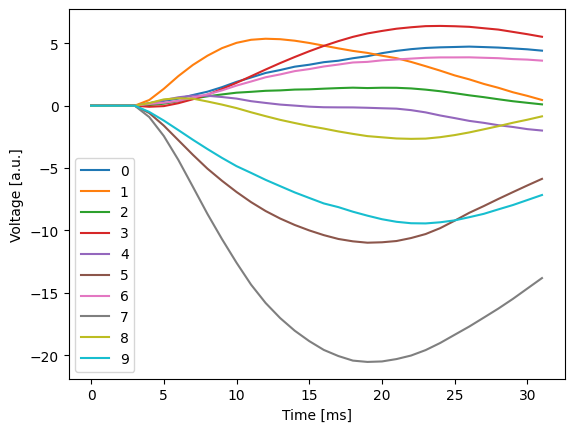

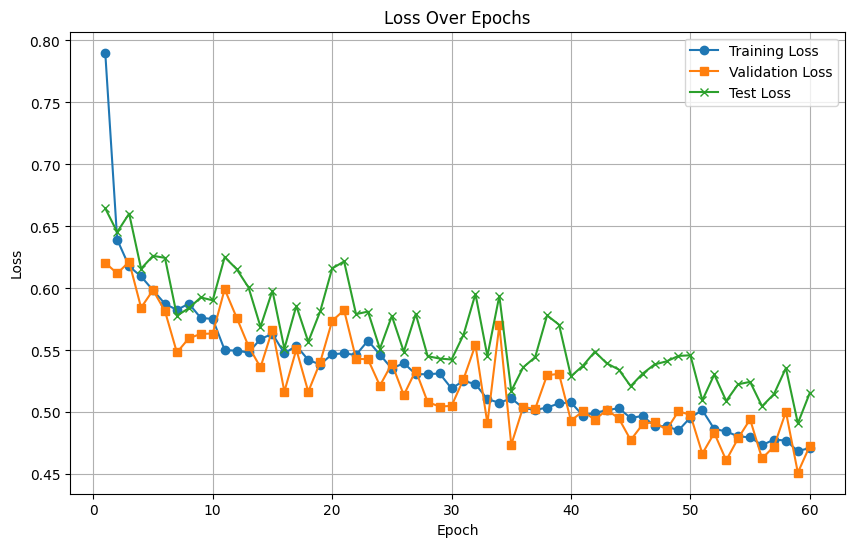

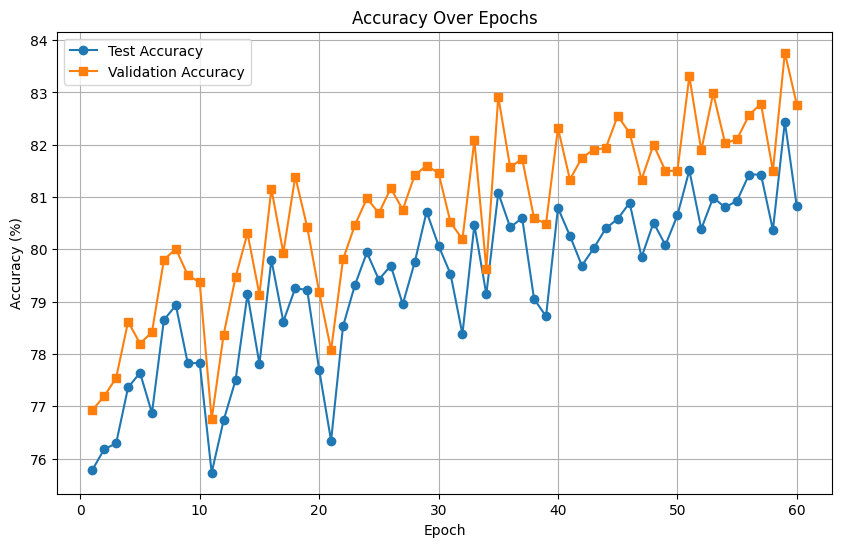

In [74]:
trained_snn = model.snn.cpu()

# Beginn 12:32 60 Epochen Ende 13:02


trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()


# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker="x")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Test Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

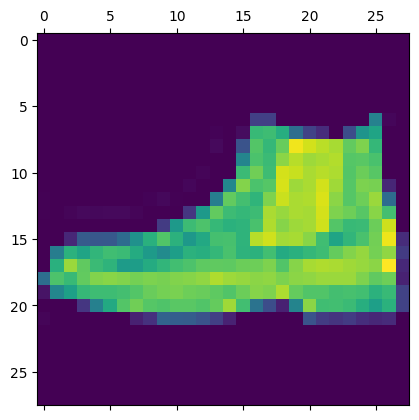

9


In [55]:
img, label = train_data[4]

plt.matshow(img[0])
plt.show()
print(label)

In [57]:
from norse.torch import ConstantCurrentLIFEncoder
import matplotlib.pyplot as plt

# Encoder and example input preparation
T = 48
example_encoder = ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)

# Define and apply the SNN model
example_snn = ConvNet()
example_readout_voltages = example_snn(example_input.unsqueeze(1))


# Encoding the input again for spikes visualization
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)

# Convert to sparse tensor and extract indices for plotting
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]


In [59]:
T = 48
LR = 0.001
EPOCHS = 60

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(T), snn=ConvNet(alpha=80), decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): ConvNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (out): LILinearCell()
  )
)

In [61]:
import numpy as np
from tqdm import trange

# Hyperparameters for early stopping
patience = 10  # Number of epochs to wait for improvement in validation loss
best_val_loss = np.inf  # Initialize the best validation loss to infinity
epochs_without_improvement = 0  # Counter for epochs without improvement

# Lists for tracking metrics
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Training phase
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test phase
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation phase
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update metrics
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Early stopping: Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        epochs_without_improvement = 0  # Reset the counter
    else:
        epochs_without_improvement += 1
    
    # If no improvement for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Validation loss hasn't improved for {patience} epochs.")
        break
    
    # Check for NaN or infinite losses and break if detected
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training stopped due to NaN or infinite loss.")
        break

    # Print progress
    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

# Final test and validation accuracy
print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

  2%|▉                                                          | 1/60 [16:42<16:25:56, 1002.66s/it]

Epoch 1/60 - Train Loss: 1.0327, Test Loss: 0.6375, Validation Loss: 0.6234, Accuracy: 76.88%, Validation Accuracy: 76.96%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

  3%|█▉                                                         | 2/60 [34:15<16:37:59, 1032.40s/it]

Epoch 2/60 - Train Loss: 0.5518, Test Loss: 0.5164, Validation Loss: 0.4945, Accuracy: 81.86%, Validation Accuracy: 82.53%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

  5%|██▉                                                        | 3/60 [54:45<17:46:08, 1122.26s/it]

Epoch 3/60 - Train Loss: 0.4701, Test Loss: 0.4729, Validation Loss: 0.4416, Accuracy: 83.27%, Validation Accuracy: 84.05%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

  7%|███▊                                                     | 4/60 [1:17:29<18:56:47, 1218.00s/it]

Epoch 4/60 - Train Loss: 0.4272, Test Loss: 0.4454, Validation Loss: 0.4096, Accuracy: 83.96%, Validation Accuracy: 85.08%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

  8%|████▊                                                    | 5/60 [1:41:04<19:41:32, 1288.96s/it]

Epoch 5/60 - Train Loss: 0.4053, Test Loss: 0.4199, Validation Loss: 0.3834, Accuracy: 84.84%, Validation Accuracy: 86.53%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

 10%|█████▋                                                   | 6/60 [2:04:40<19:58:50, 1332.05s/it]

Epoch 6/60 - Train Loss: 0.3802, Test Loss: 0.4109, Validation Loss: 0.3677, Accuracy: 85.21%, Validation Accuracy: 86.90%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

 12%|██████▋                                                  | 7/60 [2:27:04<19:40:14, 1336.13s/it]

Epoch 7/60 - Train Loss: 0.3680, Test Loss: 0.4057, Validation Loss: 0.3528, Accuracy: 85.52%, Validation Accuracy: 87.28%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

 13%|███████▌                                                 | 8/60 [2:48:42<19:07:16, 1323.78s/it]

Epoch 8/60 - Train Loss: 0.3554, Test Loss: 0.3961, Validation Loss: 0.3369, Accuracy: 85.84%, Validation Accuracy: 88.11%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

 15%|████████▌                                                | 9/60 [3:09:36<18:26:44, 1302.05s/it]

Epoch 9/60 - Train Loss: 0.3446, Test Loss: 0.3970, Validation Loss: 0.3429, Accuracy: 85.98%, Validation Accuracy: 87.66%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

 17%|█████████▎                                              | 10/60 [3:28:43<17:25:09, 1254.20s/it]

Epoch 10/60 - Train Loss: 0.3337, Test Loss: 0.3879, Validation Loss: 0.3271, Accuracy: 86.32%, Validation Accuracy: 88.21%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

 18%|██████████▎                                             | 11/60 [3:47:11<16:27:47, 1209.55s/it]

Epoch 11/60 - Train Loss: 0.3250, Test Loss: 0.3834, Validation Loss: 0.3163, Accuracy: 86.25%, Validation Accuracy: 88.83%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

 20%|███████████▏                                            | 12/60 [4:05:57<15:47:20, 1184.17s/it]

Epoch 12/60 - Train Loss: 0.3202, Test Loss: 0.3855, Validation Loss: 0.3182, Accuracy: 86.07%, Validation Accuracy: 88.40%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

 22%|████████████▏                                           | 13/60 [4:24:46<15:14:19, 1167.23s/it]

Epoch 13/60 - Train Loss: 0.3141, Test Loss: 0.3773, Validation Loss: 0.2943, Accuracy: 86.56%, Validation Accuracy: 89.27%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

 23%|█████████████                                           | 14/60 [4:43:11<14:40:31, 1148.50s/it]

Epoch 14/60 - Train Loss: 0.3070, Test Loss: 0.3755, Validation Loss: 0.2989, Accuracy: 86.20%, Validation Accuracy: 89.12%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

 25%|██████████████                                          | 15/60 [5:01:26<14:09:22, 1132.50s/it]

Epoch 15/60 - Train Loss: 0.2999, Test Loss: 0.3666, Validation Loss: 0.2886, Accuracy: 86.51%, Validation Accuracy: 89.78%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

 27%|██████████████▉                                         | 16/60 [5:20:45<13:56:20, 1140.47s/it]

Epoch 16/60 - Train Loss: 0.2924, Test Loss: 0.3693, Validation Loss: 0.2865, Accuracy: 86.66%, Validation Accuracy: 89.58%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

 28%|███████████████▊                                        | 17/60 [5:39:19<13:31:33, 1132.41s/it]

Epoch 17/60 - Train Loss: 0.2927, Test Loss: 0.3642, Validation Loss: 0.2688, Accuracy: 86.88%, Validation Accuracy: 90.31%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

 30%|████████████████▊                                       | 18/60 [5:58:03<13:10:59, 1129.99s/it]

Epoch 18/60 - Train Loss: 0.2773, Test Loss: 0.3771, Validation Loss: 0.2672, Accuracy: 86.55%, Validation Accuracy: 90.30%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

 32%|█████████████████▋                                      | 19/60 [6:10:41<11:35:43, 1018.13s/it]

Epoch 19/60 - Train Loss: 0.2751, Test Loss: 0.3772, Validation Loss: 0.2689, Accuracy: 86.62%, Validation Accuracy: 89.98%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

 33%|███████████████████                                      | 20/60 [6:22:49<10:20:42, 931.06s/it]

Epoch 20/60 - Train Loss: 0.2698, Test Loss: 0.3753, Validation Loss: 0.2653, Accuracy: 86.60%, Validation Accuracy: 90.30%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

 35%|████████████████████▎                                     | 21/60 [6:34:58<9:25:42, 870.32s/it]

Epoch 21/60 - Train Loss: 0.2668, Test Loss: 0.3632, Validation Loss: 0.2493, Accuracy: 86.91%, Validation Accuracy: 90.92%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

 37%|█████████████████████▎                                    | 22/60 [6:46:58<8:42:38, 825.23s/it]

Epoch 22/60 - Train Loss: 0.2593, Test Loss: 0.3632, Validation Loss: 0.2444, Accuracy: 87.14%, Validation Accuracy: 91.18%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

 38%|██████████████████████▏                                   | 23/60 [6:58:43<8:06:45, 789.34s/it]

Epoch 23/60 - Train Loss: 0.2538, Test Loss: 0.3813, Validation Loss: 0.2504, Accuracy: 86.55%, Validation Accuracy: 90.78%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

 40%|███████████████████████▏                                  | 24/60 [7:10:27<7:38:12, 763.68s/it]

Epoch 24/60 - Train Loss: 0.2470, Test Loss: 0.3809, Validation Loss: 0.2387, Accuracy: 86.70%, Validation Accuracy: 91.12%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

 42%|████████████████████████▏                                 | 25/60 [7:22:14<7:15:28, 746.52s/it]

Epoch 25/60 - Train Loss: 0.2454, Test Loss: 0.3815, Validation Loss: 0.2447, Accuracy: 86.73%, Validation Accuracy: 90.90%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

 43%|█████████████████████████▏                                | 26/60 [7:33:58<6:55:50, 733.82s/it]

Epoch 26/60 - Train Loss: 0.2414, Test Loss: 0.3723, Validation Loss: 0.2264, Accuracy: 87.40%, Validation Accuracy: 91.89%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

 45%|██████████████████████████                                | 27/60 [7:45:40<6:38:26, 724.44s/it]

Epoch 27/60 - Train Loss: 0.2322, Test Loss: 0.3716, Validation Loss: 0.2237, Accuracy: 86.81%, Validation Accuracy: 91.82%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

 47%|███████████████████████████                               | 28/60 [7:57:28<6:23:36, 719.25s/it]

Epoch 28/60 - Train Loss: 0.2296, Test Loss: 0.3725, Validation Loss: 0.2182, Accuracy: 86.81%, Validation Accuracy: 91.88%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

 48%|████████████████████████████                              | 29/60 [8:09:34<6:12:45, 721.48s/it]

Epoch 29/60 - Train Loss: 0.2249, Test Loss: 0.3866, Validation Loss: 0.2183, Accuracy: 87.22%, Validation Accuracy: 91.87%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

 50%|█████████████████████████████                             | 30/60 [8:21:43<6:01:50, 723.68s/it]

Epoch 30/60 - Train Loss: 0.2203, Test Loss: 0.3787, Validation Loss: 0.2053, Accuracy: 87.06%, Validation Accuracy: 92.19%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

 52%|█████████████████████████████▉                            | 31/60 [8:33:50<5:50:15, 724.69s/it]

Epoch 31/60 - Train Loss: 0.2174, Test Loss: 0.3844, Validation Loss: 0.1975, Accuracy: 87.10%, Validation Accuracy: 92.68%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

 53%|██████████████████████████████▉                           | 32/60 [8:45:58<5:38:36, 725.60s/it]

Epoch 32/60 - Train Loss: 0.2217, Test Loss: 0.3912, Validation Loss: 0.2074, Accuracy: 86.86%, Validation Accuracy: 92.42%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

 55%|███████████████████████████████▉                          | 33/60 [8:58:08<5:27:06, 726.92s/it]

Epoch 33/60 - Train Loss: 0.2115, Test Loss: 0.3770, Validation Loss: 0.1899, Accuracy: 87.47%, Validation Accuracy: 92.84%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

 57%|████████████████████████████████▊                         | 34/60 [9:09:50<5:11:44, 719.38s/it]

Epoch 34/60 - Train Loss: 0.2065, Test Loss: 0.3847, Validation Loss: 0.1882, Accuracy: 87.26%, Validation Accuracy: 92.87%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

 58%|█████████████████████████████████▊                        | 35/60 [9:21:34<4:57:51, 714.85s/it]

Epoch 35/60 - Train Loss: 0.2063, Test Loss: 0.3915, Validation Loss: 0.1918, Accuracy: 86.55%, Validation Accuracy: 92.89%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

 60%|██████████████████████████████████▊                       | 36/60 [9:33:18<4:44:36, 711.50s/it]

Epoch 36/60 - Train Loss: 0.2015, Test Loss: 0.3920, Validation Loss: 0.1821, Accuracy: 86.66%, Validation Accuracy: 93.41%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

 62%|███████████████████████████████████▊                      | 37/60 [9:45:00<4:31:44, 708.90s/it]

Epoch 37/60 - Train Loss: 0.1921, Test Loss: 0.3974, Validation Loss: 0.1836, Accuracy: 86.74%, Validation Accuracy: 93.32%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

 63%|████████████████████████████████████▋                     | 38/60 [9:56:47<4:19:40, 708.19s/it]

Epoch 38/60 - Train Loss: 0.1922, Test Loss: 0.3953, Validation Loss: 0.1760, Accuracy: 86.93%, Validation Accuracy: 93.60%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

 65%|█████████████████████████████████████                    | 39/60 [10:08:32<4:07:31, 707.22s/it]

Epoch 39/60 - Train Loss: 0.1871, Test Loss: 0.3938, Validation Loss: 0.1652, Accuracy: 87.37%, Validation Accuracy: 93.97%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

 67%|██████████████████████████████████████                   | 40/60 [10:20:19<3:55:45, 707.26s/it]

Epoch 40/60 - Train Loss: 0.1847, Test Loss: 0.4034, Validation Loss: 0.1739, Accuracy: 87.03%, Validation Accuracy: 93.86%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

 68%|██████████████████████████████████████▉                  | 41/60 [10:32:34<3:46:32, 715.38s/it]

Epoch 41/60 - Train Loss: 0.1790, Test Loss: 0.4045, Validation Loss: 0.1712, Accuracy: 87.33%, Validation Accuracy: 93.69%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

 70%|███████████████████████████████████████▉                 | 42/60 [10:44:47<3:36:12, 720.72s/it]

Epoch 42/60 - Train Loss: 0.1829, Test Loss: 0.3942, Validation Loss: 0.1596, Accuracy: 87.16%, Validation Accuracy: 94.07%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

 72%|████████████████████████████████████████▊                | 43/60 [10:57:00<3:25:14, 724.40s/it]

Epoch 43/60 - Train Loss: 0.1792, Test Loss: 0.4067, Validation Loss: 0.1630, Accuracy: 87.14%, Validation Accuracy: 93.85%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

 73%|█████████████████████████████████████████▊               | 44/60 [11:09:12<3:13:49, 726.87s/it]

Epoch 44/60 - Train Loss: 0.1738, Test Loss: 0.4080, Validation Loss: 0.1556, Accuracy: 87.09%, Validation Accuracy: 94.33%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████▊              | 45/60 [11:21:23<3:01:57, 727.84s/it]

Epoch 45/60 - Train Loss: 0.1686, Test Loss: 0.4110, Validation Loss: 0.1572, Accuracy: 87.24%, Validation Accuracy: 93.98%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████▋             | 46/60 [11:33:09<2:48:18, 721.29s/it]

Epoch 46/60 - Train Loss: 0.1645, Test Loss: 0.4056, Validation Loss: 0.1560, Accuracy: 87.14%, Validation Accuracy: 94.26%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████▋            | 47/60 [11:44:56<2:35:21, 717.00s/it]

Epoch 47/60 - Train Loss: 0.1629, Test Loss: 0.4253, Validation Loss: 0.1493, Accuracy: 86.72%, Validation Accuracy: 94.68%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████▌           | 48/60 [11:56:42<2:22:45, 713.81s/it]

Epoch 48/60 - Train Loss: 0.1571, Test Loss: 0.4064, Validation Loss: 0.1409, Accuracy: 87.41%, Validation Accuracy: 94.97%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

 82%|██████████████████████████████████████████████▌          | 49/60 [12:08:32<2:10:39, 712.68s/it]

Epoch 49/60 - Train Loss: 0.1499, Test Loss: 0.4245, Validation Loss: 0.1436, Accuracy: 86.71%, Validation Accuracy: 94.87%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████▌         | 50/60 [12:20:18<1:58:27, 710.76s/it]

Epoch 50/60 - Train Loss: 0.1480, Test Loss: 0.4221, Validation Loss: 0.1369, Accuracy: 86.98%, Validation Accuracy: 95.31%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████▍        | 51/60 [12:32:25<1:47:19, 715.52s/it]

Epoch 51/60 - Train Loss: 0.1536, Test Loss: 0.4238, Validation Loss: 0.1323, Accuracy: 87.40%, Validation Accuracy: 95.21%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████▍       | 52/60 [12:44:43<1:36:17, 722.24s/it]

Epoch 52/60 - Train Loss: 0.1474, Test Loss: 0.4372, Validation Loss: 0.1327, Accuracy: 86.57%, Validation Accuracy: 95.21%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████▎      | 53/60 [12:57:00<1:24:47, 726.78s/it]

Epoch 53/60 - Train Loss: 0.1414, Test Loss: 0.4468, Validation Loss: 0.1325, Accuracy: 86.73%, Validation Accuracy: 95.06%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████▎     | 54/60 [13:09:20<1:13:04, 730.80s/it]

Epoch 54/60 - Train Loss: 0.1508, Test Loss: 0.4446, Validation Loss: 0.1468, Accuracy: 86.63%, Validation Accuracy: 94.59%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

 92%|████████████████████████████████████████████████████▎    | 55/60 [13:21:42<1:01:10, 734.05s/it]

Epoch 55/60 - Train Loss: 0.1512, Test Loss: 0.4453, Validation Loss: 0.1706, Accuracy: 86.16%, Validation Accuracy: 93.33%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████    | 56/60 [13:34:32<49:38, 744.71s/it]

Epoch 56/60 - Train Loss: 0.1440, Test Loss: 0.4407, Validation Loss: 0.1305, Accuracy: 86.78%, Validation Accuracy: 95.38%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████   | 57/60 [13:49:32<39:34, 791.56s/it]

Epoch 57/60 - Train Loss: 0.1387, Test Loss: 0.4339, Validation Loss: 0.1150, Accuracy: 87.10%, Validation Accuracy: 96.08%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████  | 58/60 [14:01:18<25:31, 765.76s/it]

Epoch 58/60 - Train Loss: 0.1362, Test Loss: 0.4702, Validation Loss: 0.1274, Accuracy: 86.99%, Validation Accuracy: 95.17%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

 98%|██████████████████████████████████████████████████████████ | 59/60 [14:13:02<12:27, 747.11s/it]

Epoch 59/60 - Train Loss: 0.1295, Test Loss: 0.4544, Validation Loss: 0.1273, Accuracy: 86.90%, Validation Accuracy: 95.29%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 60/60 [14:24:44<00:00, 864.75s/it]

Epoch 60/60 - Train Loss: 0.1254, Test Loss: 0.4597, Validation Loss: 0.1187, Accuracy: 87.15%, Validation Accuracy: 95.62%
Final Test Accuracy: 87.15%
Final Validation Accuracy: 95.62%


torch.Size([32, 1, 10])


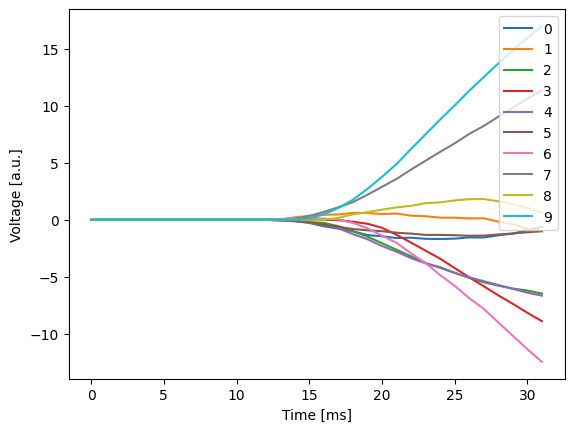

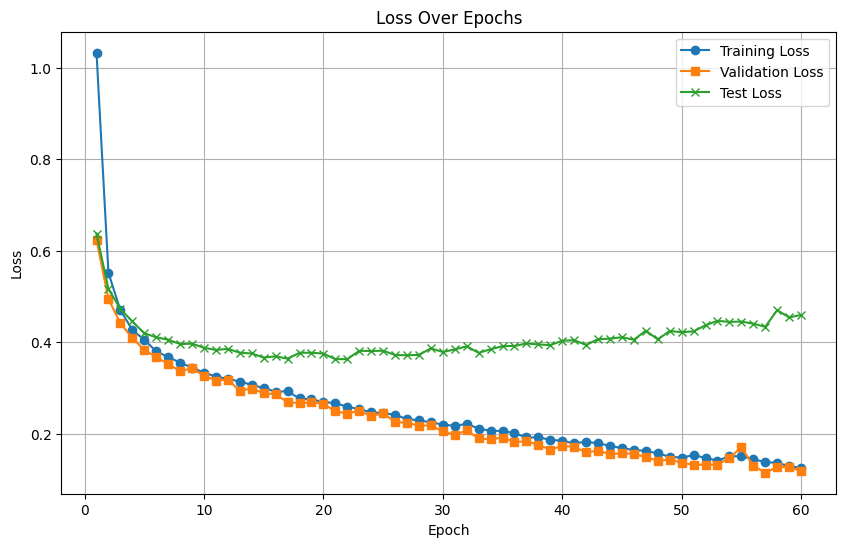

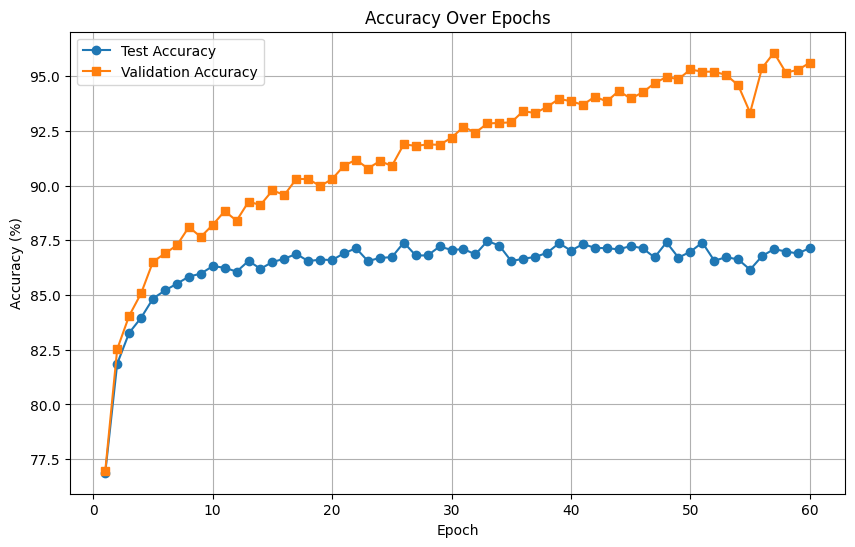

In [63]:
trained_snn = model.snn.cpu()

# Beginn 19:47 60 Epochen Ende 11:31 --> 14 Stunden 24 Minuten


trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()


# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker="x")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Test Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


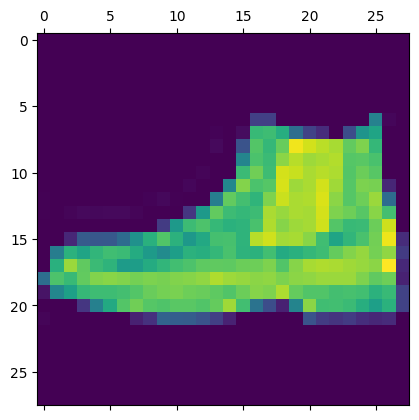

In [69]:
plt.matshow(np.squeeze(img, 0))